In [3]:
# Importing modules
import pandas as pd
import numpy as np

# Read in dataset
dataset = pd.read_csv("bank_data.csv")

# Print the first few rows of the DataFrame
print(dataset.head(5))
print(dataset.info())

     id  expected_recovery_amount  actual_recovery_amount recovery_strategy  \
0  2030                       194                 263.540  Level 0 Recovery   
1  1150                       486                 416.090  Level 0 Recovery   
2   380                       527                 429.350  Level 0 Recovery   
3  1838                       536                 296.990  Level 0 Recovery   
4  1995                       541                 346.385  Level 0 Recovery   

   age     sex  
0   19    Male  
1   25  Female  
2   27    Male  
3   25    Male  
4   34    Male  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-nu

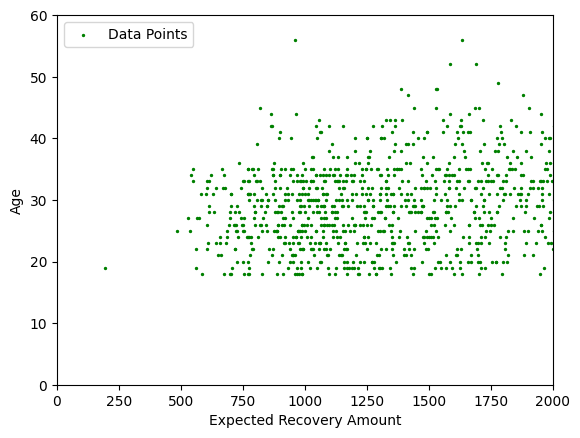

In [4]:
# Scatter plot of Age vs. Expected Recovery Amount
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=dataset['expected_recovery_amount'], y=dataset['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(['Data Points'], loc=2)

In [5]:
# Performing Kruskal-Wallis test to see if there are significant differences in age distributions between recovery levels

# Import stats module
from scipy import stats

# Compute average age just below and above the threshold
era_900_1100 = dataset.loc[(dataset['expected_recovery_amount']<1100) &
                      (dataset['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_age = era_900_1100.loc[dataset['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[dataset['recovery_strategy']=="Level 1 Recovery"]['age']


stats.kruskal(Level_0_age,Level_1_age) # pvalue > .05 indicates probability of random chance in age differences

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

In [7]:
# Create crosstab to inspect the distribution of females vs males at different recovery strategy levels and perform a chi-square test for independence

# Number of customers in each category
crosstab = pd.crosstab(dataset.loc[(dataset['expected_recovery_amount']<1100) &
                              (dataset['expected_recovery_amount']>=900)]['recovery_strategy'],
                       dataset['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val #p_val > .05 not considered statistically significant

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55


0.5377947810444592

Text(0, 0.5, 'Actual Recovery Amount')

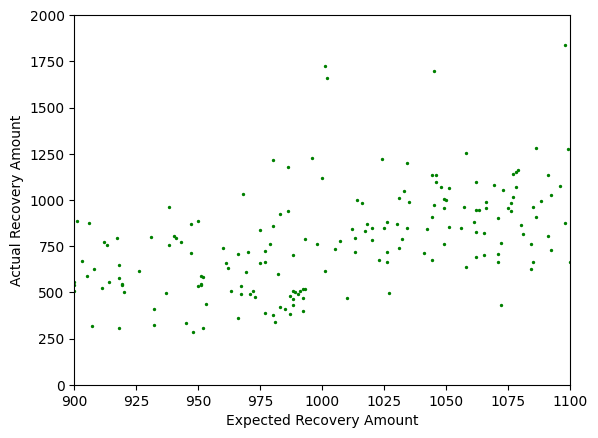

In [11]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.scatter(x=dataset['expected_recovery_amount'], y=dataset['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")

In [12]:
# Perform Kruskal-Wallis test on actual recovery amounts by recovery strategy for two different ranges of expected recovery amounts

# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[dataset['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[dataset['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual,Level_1_actual)) # pvalue indicates statistically significant differences

# Repeat for a smaller range of $950 to $1050
era_950_1050 = dataset.loc[(dataset['expected_recovery_amount']<1050) &
                      (dataset['expected_recovery_amount']>=950)]

Level_0_actual = era_950_1050.loc[dataset['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[dataset['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual,Level_1_actual)) # pvalue indicates statistically significant differences


KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


In [13]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = era_900_1100["expected_recovery_amount"]
y = era_900_1100["actual_recovery_amount"]
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Thu, 06 Jun 2024   Prob (F-statistic):           1.56e-13
Time:                            21:29:28   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
dataset['indicator_1000'] = np.where(dataset['expected_recovery_amount'] < 1000, 0, 1)
era_900_1100 = dataset.loc[(dataset['expected_recovery_amount']<1100) &
                      (dataset['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[["expected_recovery_amount", "indicator_1000"]]
y = era_900_1100["actual_recovery_amount"]
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Thu, 06 Jun 2024   Prob (F-statistic):           1.83e-15
Time:                            02:25:41   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = dataset.loc[(dataset['expected_recovery_amount']<1050) &
                      (dataset['expected_recovery_amount']>=950)]

# Define X and y
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Thu, 06 Jun 2024   Prob (F-statistic):           1.12e-07
Time:                            02:26:52   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""